<a href="https://colab.research.google.com/github/jeeva-18/Deep-learning-projects/blob/main/101_FoodVisionModel_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vision with Food101 dataset 

we are going to use the dataset from the Tensorflow datasets 
you can check up the tensorflow_datasets documentation for the 



Food 101-Description:
This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

## 1.Download our data 

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
list_datasets = tfds.list_builders()
print('food101' in list_datasets) # checking for our dataset presence

True


In [ ]:
# it will download the data into our sytems if you are using your local computer it will download lots of data  
(train_data,test_data),df_info = tfds.load('food101',
                                           split=['train','validation'], # in our case we have training and validation but some dataset have testing too
                                           shuffle_files=True, # we are shuffle our files to some randomness in our data 
                                           as_supervised=True, # beacuse our dataset is supervised 
                                           with_info=True) # getting metadata about our dataset

## 2.Exploring about the dataset


In [ ]:
#features of the dataset
df_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [ ]:
# getting the class names 

class_names = df_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# lets see some info about images and labels
for img ,labels in train_data.take(1): # .take method will take one sample from the data and every time we rn these we get random values because we set shuffle = True 
  print(f'''
  image shape: {img.shape}
  image dtype: {img.dtype}
  label : {labels}
  label name: {class_names[labels.numpy()]}
  '''
  )


  image shape: (512, 512, 3)
  image dtype: <dtype: 'uint8'>
  label : 72
  label name: pancakes
  


lets visualize some of the images

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
for i,(img ,labels) in enumerate(train_data.take(9)):
  plt.subplot(3,3,i+1)
  plt.imshow(img)
  plt.title(class_names[labels.numpy()])
  plt.axis(False)

## 3.preprocess our data

In [ ]:
# lets create a function that will  preprocess our data

def preprocess_image_data(images,labels,img_size=(224,224)):
  '''
  This function will reduce image size and change dtype int float32

  '''
  image  = tf.image.resize(images,img_size)

  return tf.cast(image,dtype=tf.float32),labels

In [ ]:
# lets check our function 

prep_img ,label = preprocess_image_data(img,labels)

print(f'image_shape : {prep_img.shape} image_dtype : {prep_img.dtype} ')

image_shape : (224, 224, 3) image_dtype : <dtype: 'float32'> 


As you can see the image is resized and dtype is changed 

## 4.Create into Batches

In [ ]:
# we are going to use map method to map our preprocess_image_data function for preprocessing

train_data = train_data.map(map_func=preprocess_image_data,num_parallel_calls=tf.data.AUTOTUNE)

# making into batches for training data

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# preprocess and making batches for testing data

test_data  = test_data.map(map_func=preprocess_image_data,num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

lets create callbacks for our model

* TensorBoard callback
* Modelcheckpoint callback

In [ ]:
import os 
import datetime
# creating the tensoboard callback
def create_tensorboard_callback(dir_name,experiment):
  date_time = datetime.datetime.now().strftime('%Y/%m/%d:%H-%M-%S')
  path = os.path.join(dir_name,experiment,date_time)
  return tf.keras.callbacks.TensorBoard(log_dir=path)

In [ ]:
# model check point callback

checkpoint_path = 'model_checkpoints/cp.cpkt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_best_only=True,
                                                         save_weights_only=True,
                                                         verbose=0)

we are going to use the mixed precision technique in this notebook 
mixed precision is the technique that changes the precision types like float32,float16 to get better performance and reduce the time on training the large datasets 

you can go through this too https://www.tensorflow.org/guide/mixed_precision

In [ ]:
# start by importing it 
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16') # this will do the job

In [ ]:
!nvidia-smi -L  # offcourse mixed precision will only works on the gpu with computing capability of above 7.0, likely our's tesla t4 got 7.5 :)  

GPU 0: Tesla T4 (UUID: GPU-aab2323a-3d8f-9a74-f435-ccb791c46749)


In [ ]:
mixed_precision.global_policy() # you can use this we utilize large amount of data

<Policy "mixed_float16">

## 5.Build our model

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 

# we are going t use the transfer learning - feature extraction

input_shape = (224,224,3)

# our base model will be EfficientNetB0
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input = layers.Input(shape=input_shape,name='input_layer')

# data_augmentation = tf.keras.Sequential([ # this is for  data augmentation
#     preprocessing.RandomRotation(20),
#     preprocessing.RandomZoom(0.2),
#     preprocessing.RandomFlip(mode='horizontal'), 
#     preprocessing.RandomWidth(0.2),
#     preprocessing.RandomHeight(0.2),
#     preprocessing.Rescaling(1/255.)      
# ])(input)

x = base_model(input)

x = layers.GlobalAveragePooling2D(name='globalAvgPooling_layer')(x)

x = layers.Dense(101,name='output_layer')(x)

output = layers.Activation(activation='softmax',dtype=tf.float32,name='prediction')(x)

model = tf.keras.Model(input,output,name='food_vision_model')

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "food_vision_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 globalAvgPooling_layer (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
 prediction (Activation)     (None, 101)               0         
                                                                 
Total params: 6,048,693
Trainable params: 129,381

## 6.Mixed precision 

In [ ]:
# mixed precision works or not 

for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
globalAvgPooling_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "mixed_float16">
prediction True float32 <Policy "float32">


In [ ]:
# lets check it in our base model

for layer in model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_4 False float32 <Policy "float32">
rescaling_5 False float32 <Policy "mixed_float16">
normalization_3 False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block1a_project_activation False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <Policy "mixed_float16">
block2a_expand_bn False float32 <Policy "mixed_float16">
block2a_expand_activation False float32 <Policy "mixed_float16">
block2a_project_conv False float32 <Policy "mixed_float16">
block2a_project_bn False float32 <Policy "mixed_float16">
block2b_expand_conv False float32 <Policy "mixed_float16">
block2b_expand_bn False float32 <Policy "mixed_float16">
block2b_expand_activation False float32 <Policy "mixed_float16">
block2b_project_conv False float32 <Po

## 7.fit our model

In [ ]:
feature_extraction_history = model.fit(train_data,
                                       epochs=5,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(.15*len(test_data)),
                                       callbacks=[create_tensorboard_callback('models','FX_efficientnet0'),checkpoint_callback])

Epoch 1/5
2368/2368 [==============================] - 238s 78ms/step - loss: 1.8379 - accuracy: 0.5541 - val_loss: 1.1653 - val_accuracy: 0.6970
Epoch 2/5
2368/2368 [==============================] - 181s 76ms/step - loss: 1.3188 - accuracy: 0.6600 - val_loss: 1.0383 - val_accuracy: 0.7182
Epoch 3/5
2368/2368 [==============================] - 181s 76ms/step - loss: 1.1842 - accuracy: 0.6899 - val_loss: 1.0035 - val_accuracy: 0.7262
Epoch 4/5
2368/2368 [==============================] - 181s 75ms/step - loss: 1.0978 - accuracy: 0.7086 - val_loss: 0.9810 - val_accuracy: 0.7373
Epoch 5/5
2368/2368 [==============================] - 183s 76ms/step - loss: 1.0393 - accuracy: 0.7245 - val_loss: 0.9727 - val_accuracy: 0.7383


In [ ]:
fx_results = model.evaluate(test_data)
fx_results

790/790 [==============================] - 53s 67ms/step - loss: 0.9661 - accuracy: 0.7362


[0.9661417603492737, 0.7361980080604553]

In [ ]:
# we are going to create a plot of history of the model
import matplotlib.pyplot as plt


def plot_history(history):
  """
  this will give you the plot of the history instance
  """
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # plot accuracy 
  plt.figure()
  plt.plot(acc,label='Training')
  plt.plot(val_acc,label='validation')
  plt.title('Accuracy scores')
  plt.legend()
  #plot loss
  plt.figure()
  plt.plot(loss,label='Training')
  plt.plot(val_loss,label='validation')
  plt.title('Losses')
  plt.legend()

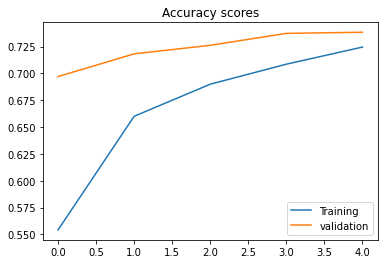

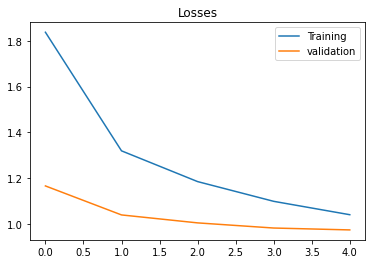

In [ ]:
plot_history(feature_extraction_history)

## 8.Fine tunned model

In [ ]:
# lets make it up

base_model.trainable = True


for layer in base_model.layers[:-20]:
  layer.trainable = False

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # we are reducing the learning rate so pretrained weights does not change too much 
              metrics=['accuracy'])

In [ ]:
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
efficientnetv2-b0 True
globalAvgPooling_layer True
output_layer True
prediction True


In [ ]:
for num,layer in enumerate(model.layers[1].layers):
  print(num,layer.name,layer.trainable)

0 input_4 False
1 rescaling_5 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

In [ ]:
# creating the callbacks to reduce learning rate of the model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

lets train the model

In [ ]:
best_model = model.fit(train_data,
                       epochs=100,
                       steps_per_epoch=len(train_data),
                       validation_data=test_data,
                       validation_steps=int(.15 * len(test_data)),
                       callbacks=[create_tensorboard_callback('models','best_fine_effb0'),
                                  early_stopping,reduce_lr,model_checkpoint])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.0128 - accuracy: 0.7341

2368/2368 [==============================] - 267s 106ms/step - loss: 1.0128 - accuracy: 0.7341 - val_loss: 0.8779 - val_accuracy: 0.7609 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8711 - accuracy: 0.7675

2368/2368 [==============================] - 250s 104ms/step - loss: 0.8711 - accuracy: 0.7675 - val_loss: 0.8239 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7879 - accuracy: 0.7898

2368/2368 [==============================] - 235s 98ms/step - loss: 0.7879 - accuracy: 0.7898 - val_loss: 0.8065 - val_accuracy: 0.7760 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.8056

2368/2368 [==============================] - 233s 97ms/step - loss: 0.7277 - accuracy: 0.8056 - val_loss: 0.7902 - val_accuracy: 0.7852 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.8205

2368/2368 [==============================] - 235s 98ms/step - loss: 0.6741 - accuracy: 0.8205 - val_loss: 0.7766 - val_accuracy: 0.7910 - lr: 1.0000e-04
Epoch 6/100
2368/2368 [==============================] - ETA: 0s - loss: 0.6221 - accuracy: 0.8334

2368/2368 [==============================] - 232s 97ms/step - loss: 0.6221 - accuracy: 0.8334 - val_loss: 0.7640 - val_accuracy: 0.7908 - lr: 1.0000e-04
Epoch 7/100
2368/2368 [==============================] - 183s 76ms/step - loss: 0.5793 - accuracy: 0.8468 - val_loss: 0.7665 - val_accuracy: 0.7945 - lr: 1.0000e-04
Epoch 8/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5408 - accuracy: 0.8573

2368/2368 [==============================] - 236s 98ms/step - loss: 0.5408 - accuracy: 0.8573 - val_loss: 0.7570 - val_accuracy: 0.7958 - lr: 1.0000e-04
Epoch 9/100
2368/2368 [==============================] - 184s 77ms/step - loss: 0.5026 - accuracy: 0.8675 - val_loss: 0.7579 - val_accuracy: 0.7950 - lr: 1.0000e-04
Epoch 10/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.8748

2368/2368 [==============================] - 242s 101ms/step - loss: 0.4758 - accuracy: 0.8748 - val_loss: 0.7513 - val_accuracy: 0.7948 - lr: 1.0000e-04
Epoch 11/100
2368/2368 [==============================] - 184s 77ms/step - loss: 0.4423 - accuracy: 0.8839 - val_loss: 0.7602 - val_accuracy: 0.7998 - lr: 1.0000e-04
Epoch 12/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4157 - accuracy: 0.8912
Epoch 12: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 190s 79ms/step - loss: 0.4157 - accuracy: 0.8912 - val_loss: 0.7647 - val_accuracy: 0.7953 - lr: 1.0000e-04
Epoch 13/100
2368/2368 [==============================] - 184s 77ms/step - loss: 0.3679 - accuracy: 0.9083 - val_loss: 0.7658 - val_accuracy: 0.7979 - lr: 2.0000e-05


In [ ]:
best_results = model.evaluate(test_data)
best_results

790/790 [==============================] - 57s 72ms/step - loss: 0.7531 - accuracy: 0.7967


[0.7531286478042603, 0.7967128753662109]

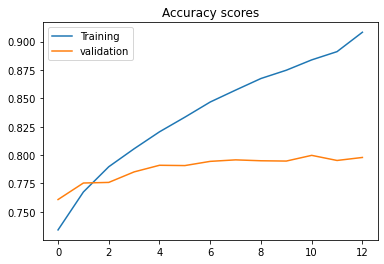

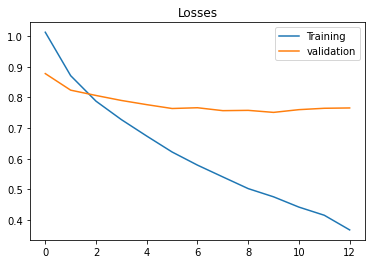

In [ ]:
plot_history(best_model)